# Notebook


In [2]:
# Account information
OANDA_ACCESS_TOKEN = "access key "
ACCOUNT_ID = "account number "
access_token = OANDA_ACCESS_TOKEN
accountID = ACCOUNT_ID
client = oandapyV20.API(access_token=access_token)
API_KEY = access_token

NameError: name 'oandapyV20' is not defined

In [ ]:
# OANDA API connection setup
api = oandapyV20.API(access_token=API_KEY, environment="practice")

# Function to fetch historical data
def get_historical_data(instrument, granularity, start, end):
    params = {
        "granularity": granularity,
        "from": start,
        "to": end,
    }
    request = instruments.InstrumentsCandles(instrument=instrument, params=params)
    response = api.request(request)
    data = response['candles']
    ohlc_data = [{'time': candle['time'], 'open': float(candle['mid']['o']), 'high': float(candle['mid']['h']),
                  'low': float(candle['mid']['l']), 'close': float(candle['mid']['c'])} for candle in data]
    df = pd.DataFrame(ohlc_data)
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)
    return df

# Define the instrument, granularity, and date range

granularity = 'D'  # Daily data
start_date = '01-01-2022'
end_date = '01-01-2023'

# Instrument 
#instrument = "EUR_USD"
#instrument = "EUR_AUD"
instrument = "EUR_JPY"
#instrument = "EUR_CHF"

# Granularity (daily)
granularity = "D"

# Fetch historical data
historical_data = get_historical_data(instrument, granularity, start_date, end_date)
data = historical_data
# Print the fetched data
#print(historical_data)

data.index= data.index.tz_localize(None)  # otherwise Quanstats will not be able to convert timezone or compare benchmark to strategy

#display (data)

In [ ]:
# Add on to Data Dataframe for Profit, Units, Balance...

# Pivot calculation 
pivot= ((data['open']+data ['low'] + data['close'])/3)
data['pivot'] = pivot          
data['previous_pivot'] = data['pivot'].shift(1)

# Create a Signal column with 1, whenever the previous pivot is greater than current open 
data.loc[data['previous_pivot'] < data['open'], 'Signal'] = 1

#End Algo Note ---- use from this point above for algorithm code 



# Start Backtest 

# Once signal 1 is created at the open, buy the open of that same day.  Sell the close.    

# Calculate daily range 
data['range']= data['high']-data['low']

# Calculate daily change 
data['change']= data['close']-data['open']

# Calculate profit
data['profit'] = data.apply(lambda row: row['change'] * 100 if row['Signal'] == 1 else 0, axis=1)

profit = data ['profit']

# Initial Balance, Cumulative Profit, Balance 
initial_balance = 10000
data['cumulative_profit'] = data['profit'].cumsum()
data['balance'] = initial_balance + data['cumulative_profit']


# Calculate 'returns' column
data['returns'] = data['profit'] / data['balance']

display(data)


,open,high,low,close,pivot,previous_pivot,Signal,range,change,profit,cumulative_profit,balance,returns
time,,,,,,,,,,,,,
2022-01-02 22:00:00,130.896,131.004,130.027,130.313,130.412000,NaN,NaN,0.977,-0.583,0.0,0.0,10000.0,0.000000
2022-01-03 22:00:00,130.260,131.463,130.226,131.090,130.525333,130.412000,NaN,1.237,0.830,0.0,0.0,10000.0,0.000000
2022-01-04 22:00:00,131.002,131.599,130.842,131.348,131.064000,130.525333,1.0,0.757,0.346,34.6,34.6,10034.6,0.003448
2022-01-05 22:00:00,131.372,131.430,130.642,130.886,130.966667,131.064000,1.0,0.788,-0.486,-48.6,-14.0,9986.0,-0.004867
2022-01-06 22:00:00,130.860,131.350,130.816,131.277,130.984333,130.966667,NaN,0.534,0.417,0.0,-14.0,9986.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22 22:00:00,140.288,141.214,140.070,141.010,140.456000,140.231333,1.0,1.144,0.722,72.2,1570.2,11570.2,0.006240
2022-12-26 22:00:00,141.232,142.274,141.136,142.023,141.463667,140.456000,1.0,1.138,0.791,79.1,1649.3,11649.3,0.006790
2022-12-27 22:00:00,142.048,142.944,141.890,142.722,142.220000,141.463667,1.0,1.054,0.674,67.4,1716.7,11716.7,0.005752


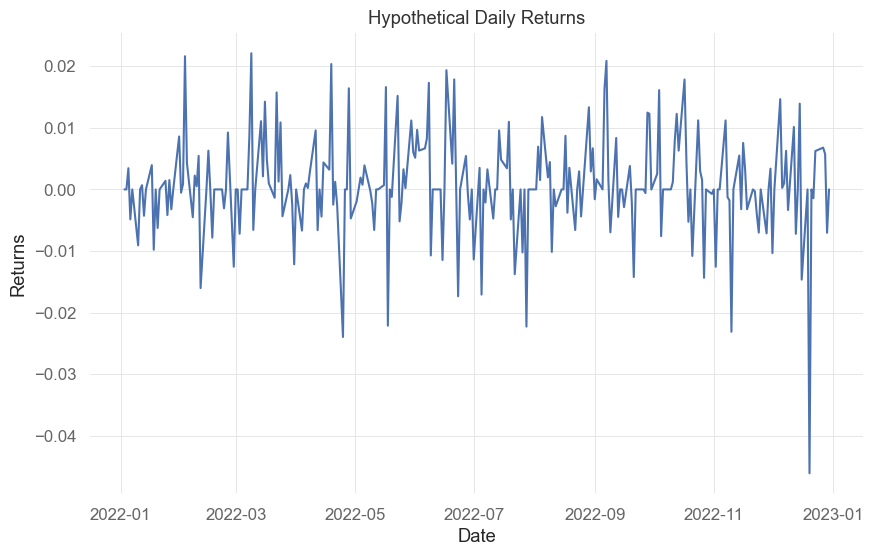

[*********************100%***********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2022-01-04   2022-01-04
End Period                 2022-12-29   2022-12-29
Risk-Free Rate             0.0%         0.0%
Time in Market             34.0%        74.0%

Cumulative Return          8.71%        14.37%
CAGR﹪                     6.04%        9.88%

Sharpe                     0.61         1.08
Prob. Sharpe Ratio         78.03%       85.58%
Smart Sharpe               0.6          1.08
Sortino                    1.74         1.54
Smart Sortino              1.73         1.53
Sortino/√2                 1.23         1.09
Smart Sortino/√2           1.23         1.08
Omega                      1.24         1.24

Max Drawdown               -5.63%       -8.37%
Longest DD Days            263          76
Volatility (ann.)          15.33%       12.97%
R^2                        0.0          0.0
Information Ratio          0.02         0.02
Calmar                  

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-10-18,2022-12-21,2022-12-29,73,-8.365201,-8.234312
2,2022-06-22,2022-07-27,2022-09-05,76,-6.708935,-6.061449
3,2022-01-05,2022-01-26,2022-02-02,29,-3.372188,-3.206576
4,2022-02-10,2022-03-02,2022-03-10,29,-3.125551,-2.422803
5,2022-04-19,2022-04-24,2022-05-29,41,-2.759893,-2.694906


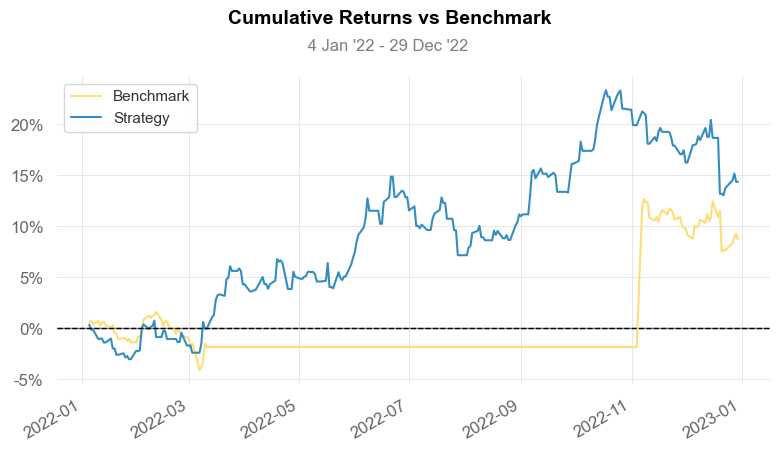

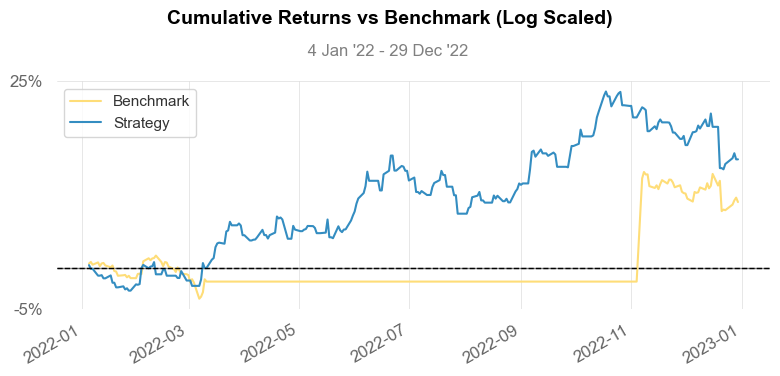

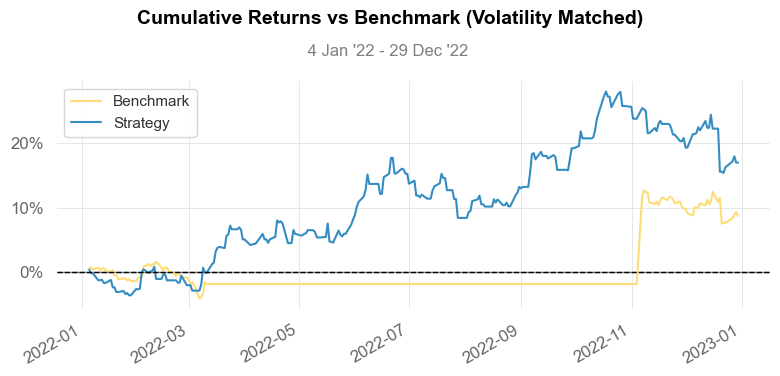

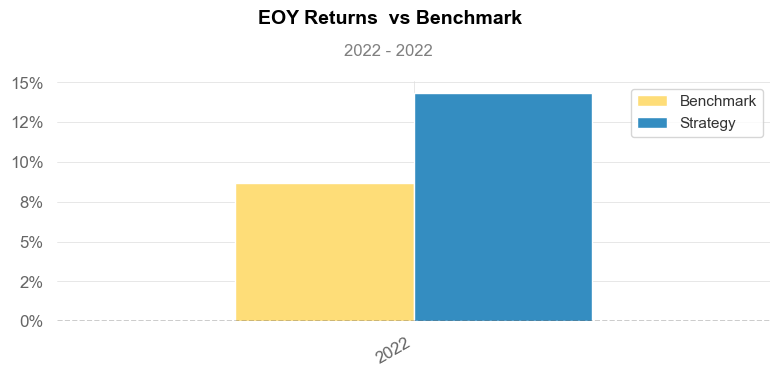

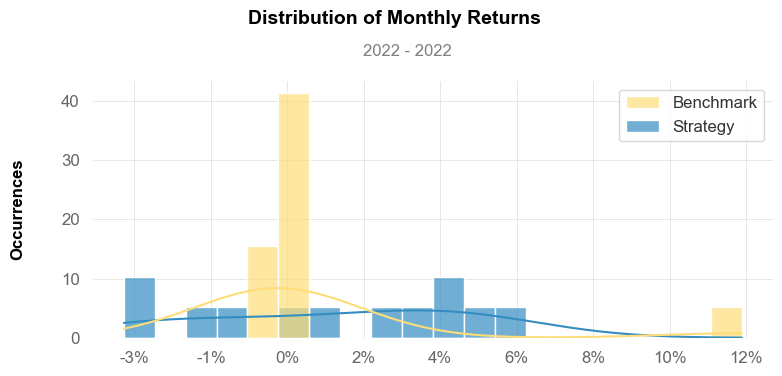

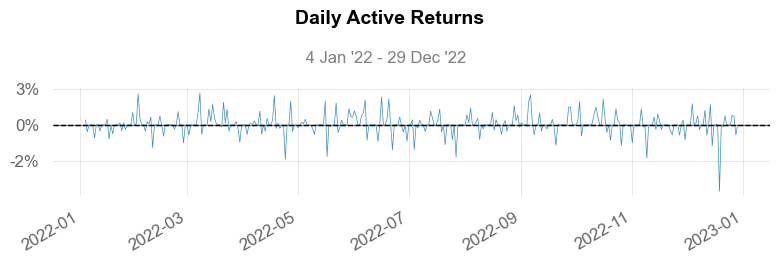

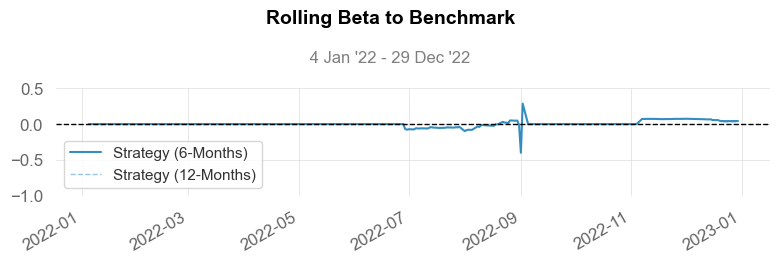

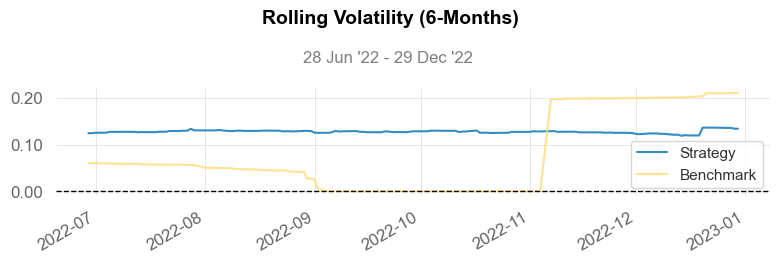

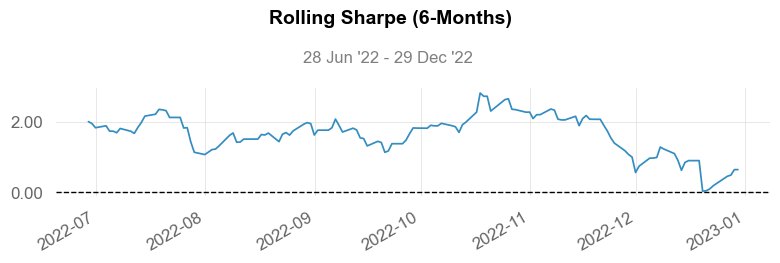

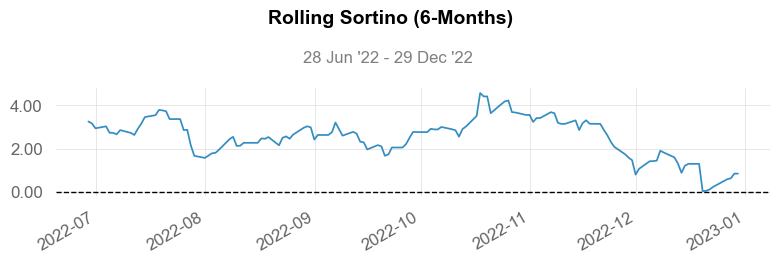

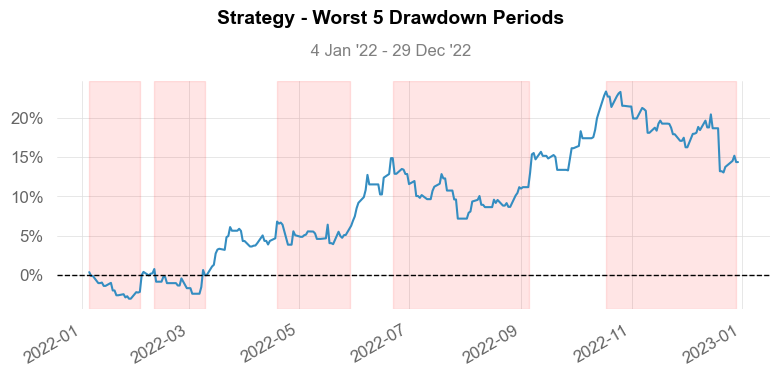

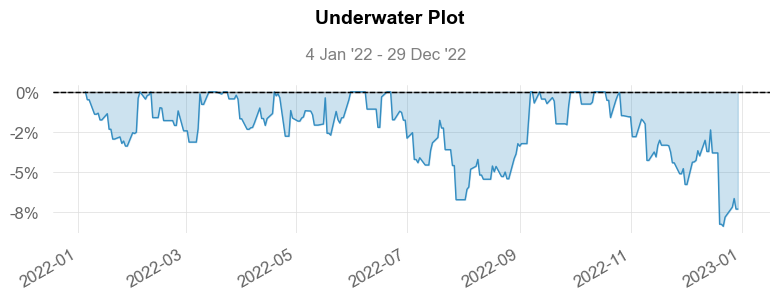

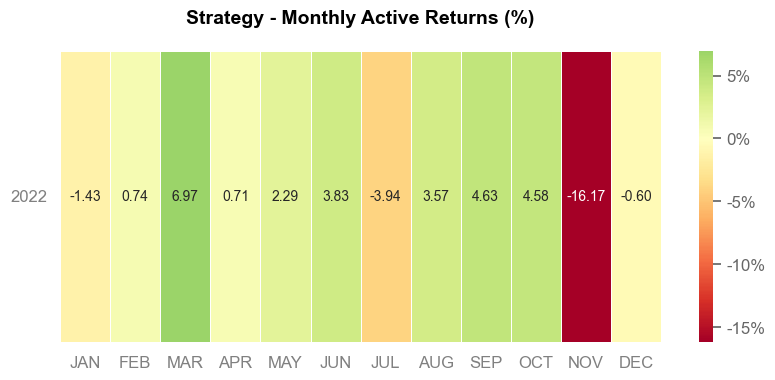

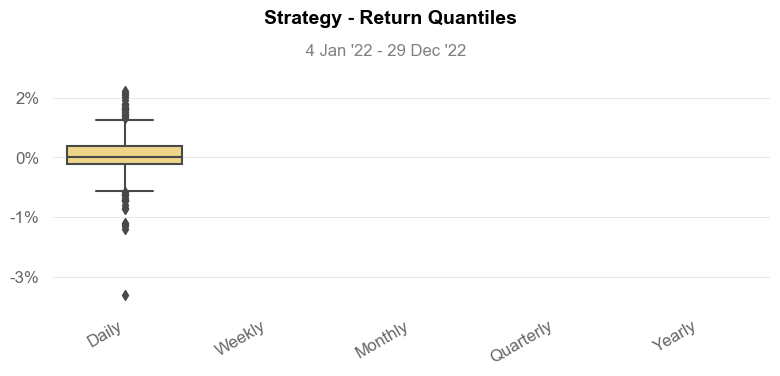

In [ ]:
# Create the line chart
sns.lineplot(x="time", y="returns", data=data)

# Customize the plot
plt.title("Hypothetical Daily Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.grid(True)

# Show the plot
plt.show()

#Quanstats#  Load returns, without having to convert to a series 
returns_series = data['returns']

benchmark = qs.utils.download_returns('eurjpy=X') # note ticker format 
qs.reports.full(returns_series , benchmark)
#qs.reports.full(benchmark)
# Html Tearsheet
qs.reports.html(returns_series , benchmark=benchmark)